In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from ast import literal_eval
import lightgbm as lgbm
import xgboost as xgb

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_extraction.text import TfidfVectorizer

import datetime

from sklearn.ensemble import GradientBoostingRegressor

# 1. DataSet

### a. Import dataset

In [2]:
data = pd.read_csv('movies_metadata.csv')

C:\Users\wanga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### b. EDA

#### Basic Statistics

In [3]:
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Basic data cleaning + EDA

In [7]:
#example offset row (showing in transpose df), row 29503 is off
data.adult.value_counts()
data.iloc[29500:29505].T

,29500,29501,29502,29503,29504
adult,False,False,False,Rune Balot goes to a casino connected to the ...,False
belongs_to_collection,NaN,"{'id': 122661, 'name': 'Mardock Scramble Colle...","{'id': 122661, 'name': 'Mardock Scramble Colle...",1.931659,NaN
budget,10000000,0,0,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,0
genres,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 53, 'name': 'Thriller'}, {'id': 16, 'n...","[{'id': 16, 'name': 'Animation'}, {'id': 878, ...","[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'id': 10770, 'name': 'TV Movie'}, {'id': 35,..."
homepage,https://twitter.com/50to1_Movie,http://m-scramble.jp/compression/,http://m-scramble.jp/exhaust/,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN
id,197583,73529,122662,2012-09-29,50794
imdb_id,tt1777595,tt1754177,tt2423504,0,tt0327698
original_language,en,ja,ja,68.0,en
original_title,50 to 1,マルドゥック・スクランブル 圧縮,マルドゥック・スクランブル 排気,"[{'iso_639_1': 'ja', 'name': '日本語'}]",The Even Stevens Movie
overview,A misfit group of New Mexico cowboys find them...,Rune Ballot is a down-and-out teen prostitute ...,Third film of the Mardock Scramble series.,Released,The Stevens think that they've won an all-expe...


In [8]:
# Similarly, row 19730, 29503, and 35587 are also off, so dropped
# Also drop id and link features
cleaned_data_1 = (
    data
    .drop([19730,29503,35587])
    .drop(columns=['homepage','imdb_id','id','poster_path'])
)
cleaned_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   original_language      45452 non-null  object 
 5   original_title         45463 non-null  object 
 6   overview               44509 non-null  object 
 7   popularity             45460 non-null  object 
 8   production_companies   45460 non-null  object 
 9   production_countries   45460 non-null  object 
 10  release_date           45376 non-null  object 
 11  revenue                45460 non-null  float64
 12  runtime                45203 non-null  float64
 13  spoken_languages       45460 non-null  object 
 14  status                 45379 non-null  object 
 15  ta

In [13]:
# Check some other features
print(cleaned_data_1.status.value_counts())
print(cleaned_data_1.adult.value_counts())
print(cleaned_data_1.original_title.value_counts())
print(cleaned_data_1.tagline.value_counts())

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64
False    45454
True         9
Name: adult, dtype: int64
Alice in Wonderland     8
Hamlet                  8
A Christmas Carol       7
The Three Musketeers    7
Cinderella              7
                       ..
La Bataille du rail     1
거미숲                     1
What Goes Up            1
12th & Delaware         1
Queerama                1
Name: original_title, Length: 43371, dtype: int64
Based on a true story.                                        7
Be careful what you wish for.                                 4
Trust no one.                                                 4
-                                                             4
Classic Albums                                                3
                                                             ..
A special force in a special kind of hell!     

(array([0.15022422, 0.01793722, 0.01121076, 0.04484305, 0.10089686,
        0.19282511, 0.2735426 , 0.12556054, 0.05829596, 0.02466368]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

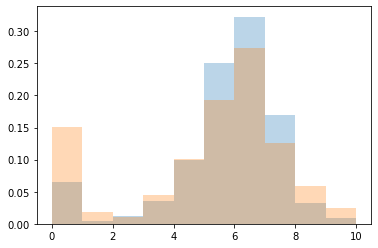

In [15]:
#compare distribution of average rating in released and other status
plt.hist(cleaned_data_1[cleaned_data_1.status=='Released'].vote_average, density=True, alpha=0.3)
plt.hist(cleaned_data_1[cleaned_data_1.status!='Released'].vote_average, density=True, alpha=0.3)

In [14]:
# Drop imbalanced features, and features with foreign languages, and tagline, which is redundant to description
cleaned_data_1_2 = cleaned_data_1.drop(columns=['adult', 'status', 'original_title','tagline'])
cleaned_data_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4491 non-null   object 
 1   budget                 45463 non-null  object 
 2   genres                 45463 non-null  object 
 3   original_language      45452 non-null  object 
 4   overview               44509 non-null  object 
 5   popularity             45460 non-null  object 
 6   production_companies   45460 non-null  object 
 7   production_countries   45460 non-null  object 
 8   release_date           45376 non-null  object 
 9   revenue                45460 non-null  float64
 10  runtime                45203 non-null  float64
 11  spoken_languages       45460 non-null  object 
 12  title                  45460 non-null  object 
 13  video                  45460 non-null  object 
 14  vote_average           45460 non-null  float64
 15  vo

#### Special format cleaning

In [22]:
def clean_list_dic(x):
    #if nan return empty string / empty list?
    if type(x)==float:
        return []
    return re.findall("'name': '(.*?)'", x)

def count_len(x):
    #take in list return count
    return len(x)

In [23]:
#Generate clean list
belongs_to_collection=cleaned_data_1_2.belongs_to_collection
belongs_to_collection_clean = belongs_to_collection.apply(clean_list_dic)
genres_clean = cleaned_data_1_2.genres.apply(clean_list_dic)
production_companies_clean=cleaned_data_1_2.production_companies.apply(clean_list_dic)
production_countries_clean = cleaned_data_1_2.production_countries.apply(clean_list_dic)
spoken_languages_clean = cleaned_data_1_2.spoken_languages.apply(clean_list_dic)

# Assign to table
cleaned_data_2 = cleaned_data_1_2.assign(
    belongs_to_collection=belongs_to_collection_clean,
    genres=genres_clean,
    production_companies=production_companies_clean,
    production_countries=production_countries_clean,
    spoken_languages=spoken_languages_clean
    )
#sample
cleaned_data_2.head().T

,0,1,2,3,4
belongs_to_collection,[Toy Story Collection],[],[Grumpy Old Men Collection],[],[Father of the Bride Collection]
budget,30000000,65000000,0,16000000,0
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy]
original_language,en,en,en,en,en
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...
popularity,21.946943,17.015539,11.7129,3.859495,8.387519
production_companies,[Pixar Animation Studios],"[TriStar Pictures, Teitler Film, Interscope Co...","[Warner Bros., Lancaster Gate]",[Twentieth Century Fox Film Corporation],"[Sandollar Productions, Touchstone Pictures]"
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America]
release_date,1995-10-30,1995-12-15,1995-12-22,1995-12-22,1995-02-10
revenue,373554033.0,262797249.0,0.0,81452156.0,76578911.0


# 2. Predictive Task

### - Regression problem, try to predict vote_average

### - Evaluation: RMSE

### Generate baseline features, split to US and others data for generalization

In [24]:
# new columns value
cleaned_data_3=cleaned_data_2.copy()
genres_count=cleaned_data_2.genres.apply(count_len)
belongs_to_collection_boolean =cleaned_data_2.belongs_to_collection.apply(count_len)==0

#-------- #Baseline features ------
revenue_fillna=cleaned_data_2.revenue.fillna(0)
popularity_fillna=cleaned_data_2.popularity.fillna(0)
vote_average_fillna = cleaned_data_2.vote_average.fillna(0)
production_companies_count=cleaned_data_2.production_companies.apply(count_len)
runtime_fillna=cleaned_data_2.runtime.fillna(cleaned_data_2.runtime.mean())
spoken_languages_count=cleaned_data_2.spoken_languages.apply(count_len)
# Vote count
vote_count=cleaned_data_2.vote_count.fillna(0).astype(int)
vote_count_log=vote_count.apply(lambda x: np.log(x+1)).fillna(0)
revenue=cleaned_data_2.revenue.fillna(0).astype(int)
revenue_log=revenue.apply(lambda x: np.log(x+1)).fillna(0)
production_countries = cleaned_data_2.production_countries

baseline_features_raw = pd.DataFrame([
    revenue_fillna.values, popularity_fillna.values, production_companies_count.values, 
    runtime_fillna.values,
    spoken_languages_count.values,
    vote_count.values,vote_count_log.values, 
    revenue_log.values, vote_average_fillna.values,
    production_countries.values]).T


baseline_features=baseline_features_raw.rename(
    columns={0:'revenue',1:'popularity',2:'production_companies_count',3:'runtime',
            4:'spoken_languages_count',5:'vote_count',
             6:'vote_count_log', 7:'revenue_log', 8:'vote_average', 
             9:'production_countries'})
baseline_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   revenue                     45463 non-null  object
 1   popularity                  45463 non-null  object
 2   production_companies_count  45463 non-null  object
 3   runtime                     45463 non-null  object
 4   spoken_languages_count      45463 non-null  object
 5   vote_count                  45463 non-null  object
 6   vote_count_log              45463 non-null  object
 7   revenue_log                 45463 non-null  object
 8   vote_average                45463 non-null  object
 9   production_countries        45463 non-null  object
dtypes: object(10)
memory usage: 3.5+ MB


In [25]:
cleaned_data_3=cleaned_data_2.assign(
    genres_count=genres_count,
    belongs_to_collection=belongs_to_collection_boolean,
    revenue=revenue_fillna,
    popularity=popularity_fillna,
    production_companies_count=production_companies_count,
    runtime=runtime_fillna,
    spoken_languages_count=spoken_languages_count,
    vote_count=vote_count,
    vote_count_log=vote_count_log
    )
cleaned_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  45463 non-null  object 
 1   budget                 45463 non-null  object 
 2   genres                 45463 non-null  object 
 3   original_language      45452 non-null  object 
 4   overview               44509 non-null  object 
 5   popularity             45460 non-null  object 
 6   production_companies   45463 non-null  object 
 7   production_countries   45463 non-null  object 
 8   release_date           45376 non-null  object 
 9   revenue                45460 non-null  float64
 10  runtime                45203 non-null  float64
 11  spoken_languages       45463 non-null  object 
 12  title                  45460 non-null  object 
 13  video                  45460 non-null  object 
 14  vote_average           45460 non-null  float64
 15  vo

In [26]:
### Split baseline dataset
baseline_features['only_produced_by_US'] = baseline_features['production_countries']\
.apply(lambda x: (len(x) == 1) and (x[0] == 'United States of America'))
baseline_us = baseline_features[baseline_features['only_produced_by_US'] == True]
baseline_other = baseline_features[baseline_features['only_produced_by_US'] == False]
baseline_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17851 entries, 0 to 45460
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   revenue                     17851 non-null  object
 1   popularity                  17851 non-null  object
 2   production_companies_count  17851 non-null  object
 3   runtime                     17851 non-null  object
 4   spoken_languages_count      17851 non-null  object
 5   vote_count                  17851 non-null  object
 6   vote_count_log              17851 non-null  object
 7   revenue_log                 17851 non-null  object
 8   vote_average                17851 non-null  object
 9   production_countries        17851 non-null  object
 10  only_produced_by_US         17851 non-null  bool  
dtypes: bool(1), object(10)
memory usage: 1.5+ MB


In [27]:
### Split cleaned_data_3 for other useful features
cleaned_data_3['only_produced_by_US'] = cleaned_data_3['production_countries']\
.apply(lambda x: (len(x) == 1) and (x[0] == 'United States of America'))
cleaned_3_us = cleaned_data_3[cleaned_data_3['only_produced_by_US'] == True]
cleaned_3_other = cleaned_data_3[cleaned_data_3['only_produced_by_US'] == False]
cleaned_3_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17851 entries, 0 to 45463
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   belongs_to_collection       17851 non-null  bool   
 1   budget                      17851 non-null  object 
 2   genres                      17851 non-null  object 
 3   original_language           17848 non-null  object 
 4   overview                    17822 non-null  object 
 5   popularity                  17851 non-null  object 
 6   production_companies        17851 non-null  object 
 7   production_countries        17851 non-null  object 
 8   release_date                17846 non-null  object 
 9   revenue                     17851 non-null  float64
 10  runtime                     17851 non-null  float64
 11  spoken_languages            17851 non-null  object 
 12  title                       17851 non-null  object 
 13  video                       178

### Build four baseline models

In [28]:
# Custom function for printing test rmse, column_to_drop: dropping unnecessary training_x data if not just vote_average
def get_rmse(n_iteration, model, df, column_to_drop = ['vote_average']):
    rmse_list = []
    for _ in range(n_iteration):
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = column_to_drop), 
                                                            df['vote_average'], test_size=0.25)
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        rmse = mean_squared_error(y_test, predicted, squared=False)
        rmse_list.append(rmse)
    print(rmse_list)
    print(np.mean(rmse_list))

In [29]:
# Change the columns to int or float
for col_name in baseline_us.columns[:-2]:
    if ('count' not in col_name) | ('log' in col_name):
        baseline_us[col_name] = baseline_us[col_name].astype('float')
    else:
        baseline_us[col_name] = baseline_us[col_name].astype('int')
baseline_us = baseline_us.drop(columns = ['production_countries', 'only_produced_by_US'])
baseline_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17851 entries, 0 to 45460
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   revenue                     17851 non-null  float64
 1   popularity                  17851 non-null  float64
 2   production_companies_count  17851 non-null  int32  
 3   runtime                     17851 non-null  float64
 4   spoken_languages_count      17851 non-null  int32  
 5   vote_count                  17851 non-null  int32  
 6   vote_count_log              17851 non-null  float64
 7   revenue_log                 17851 non-null  float64
 8   vote_average                17851 non-null  float64
dtypes: float64(6), int32(3)
memory usage: 1.2 MB


C:\Users\wanga\AppData\Local\Temp/ipykernel_1572/4140288815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_us[col_name] = baseline_us[col_name].astype('float')
C:\Users\wanga\AppData\Local\Temp/ipykernel_1572/4140288815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_us[col_name] = baseline_us[col_name].astype('int')


In [30]:
# Change the columns to int or float
for col_name in baseline_other.columns[:-2]:
    if ('count' not in col_name) | ('log' in col_name):
        baseline_other[col_name] = baseline_other[col_name].astype('float')
    else:
        baseline_other[col_name] = baseline_other[col_name].astype('int')
baseline_other = baseline_other.drop(columns = ['production_countries', 'only_produced_by_US'])
baseline_other.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27612 entries, 6 to 45462
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   revenue                     27612 non-null  float64
 1   popularity                  27612 non-null  float64
 2   production_companies_count  27612 non-null  int32  
 3   runtime                     27612 non-null  float64
 4   spoken_languages_count      27612 non-null  int32  
 5   vote_count                  27612 non-null  int32  
 6   vote_count_log              27612 non-null  float64
 7   revenue_log                 27612 non-null  float64
 8   vote_average                27612 non-null  float64
dtypes: float64(6), int32(3)
memory usage: 1.8 MB


C:\Users\wanga\AppData\Local\Temp/ipykernel_1572/1024592939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_other[col_name] = baseline_other[col_name].astype('float')
C:\Users\wanga\AppData\Local\Temp/ipykernel_1572/1024592939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_other[col_name] = baseline_other[col_name].astype('int')


### Linear regressor

In [30]:
# US
regr = linear_model.LinearRegression()
get_rmse(10, regr, baseline_us)

[1.541024464559333, 1.553730218143317, 1.5637766350385909, 1.546356482965163, 1.5815493618087935, 1.5612585894699256, 1.5261871779271245, 1.5862010337991428, 1.5566510501192927, 1.566047914080957]
1.558278292791164


In [31]:
# Other
regr = linear_model.LinearRegression()
get_rmse(10, regr, baseline_other)

[1.7638343741587574, 1.7554524387867902, 1.7633678678226943, 1.7446382899178552, 1.726473703231189, 1.7597952652538924, 1.760115996951715, 1.766974469266893, 1.7820908334791028, 1.7494655732355304]
1.7572208812104417


### RandomForestRegressor

In [95]:
# US
rfr = RandomForestRegressor()
get_rmse(10, rfr, baseline_us)

[1.2069795973319235, 1.2455749142085628, 1.2312447281313323, 1.2215050538003438, 1.2016265134558315, 1.2150098656226562, 1.208850599774224, 1.196736317481136, 1.2189903507579005, 1.2014174187294104]
1.214793535929332


In [96]:
# Other
rfr = RandomForestRegressor()
get_rmse(10, rfr, baseline_other)

[1.2756629675229385, 1.2322681339332437, 1.259074346255091, 1.2578864338608942, 1.2596519932181756, 1.2451530635316566, 1.262157195477449, 1.2725780841291698, 1.2442210890606022, 1.2678601016089746]
1.2576513408598196


### XGBRegressor

In [97]:
# US
xg_reg = xgb.XGBRegressor()
get_rmse(5, xg_reg, baseline_us)

[1.1968252480544685, 1.170491356708426, 1.222866317875089, 1.161083758868381, 1.2043523971298395]
1.1911238157272408


In [98]:
# Other
xg_reg = xgb.XGBRegressor()
get_rmse(5, xg_reg, baseline_other)

[1.2215358567337218, 1.2042433800026706, 1.2163568725164202, 1.2337417575545122, 1.2189887667070374]
1.2189733267028724


### LightGBM

In [40]:
# US
lgbmR = lgbm.LGBMRegressor()
get_rmse(1, lgbmR, baseline_us)

[1.1822831535582157]
1.1822831535582157


In [41]:
# Other
lgbmR = lgbm.LGBMRegressor()
get_rmse(1, lgbmR, baseline_other)

[1.1987228881380372]
1.1987228881380372


# 3. Model

## Picking RandomForest Regressor and XGBRegressor to tune

### RandomForest

In [44]:
## Prevent overfit for RandomForest (tune the n_estimators and max_depth)
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200, 300], 'max_depth':[10, 20, 30, 50]}
rfr = RandomForestRegressor()
gsc = GridSearchCV(rfr, parameters)
gsc.fit(baseline_us.drop(columns = ['vote_average']), baseline_us.vote_average)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30, 50],
                         'n_estimators': [50, 100, 200, 300]})

In [46]:
gsc.best_params_

{'max_depth': 10, 'n_estimators': 300}

In [47]:
## Prevent overfit for RandomForest (tune the n_estimators and max_depth): set more estimator, less max_depth
parameters = {'n_estimators':[300, 400, 500], 'max_depth':[3, 5, 8, 10]}
rfr = RandomForestRegressor()
gsc = GridSearchCV(rfr, parameters)
gsc.fit(baseline_us.drop(columns = ['vote_average']), baseline_us.vote_average)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 8, 10],
                         'n_estimators': [300, 400, 500]})

In [49]:
gsc.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [50]:
## Prevent overfit for RandomForest (tune the n_estimators and max_depth): set more estimator, less max_depth
parameters = {'n_estimators':[500, 600, 700], 'max_depth':[10]}
rfr = RandomForestRegressor()
gsc = GridSearchCV(rfr, parameters)
gsc.fit(baseline_us.drop(columns = ['vote_average']), baseline_us.vote_average)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10], 'n_estimators': [500, 600, 700]})

In [51]:
gsc.best_params_

{'max_depth': 10, 'n_estimators': 600}

In [52]:
# US
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, baseline_us)

[1.137877068609378, 1.1553332869243573, 1.130035808742907, 1.2207452095482498, 1.1398371594201289, 1.1431911726680304, 1.1669625306231837, 1.1276084839612475, 1.1605323561167546, 1.1616799249073788]
1.1543803001521613


In [53]:
# Other
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, baseline_other)

[1.2117937443538622, 1.1938918531122635, 1.2034367808544137, 1.1838250173214118, 1.1804500061984733, 1.19201761850368, 1.2003879873295473, 1.1964933844480907, 1.2152532943247587, 1.1945851890923656]
1.1972134875538867


### XGBRegressor

In [91]:
%%time
#### US data: best parameters so far ####
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, baseline_us)

[1.139744500311425, 1.1675527799878225, 1.18509835915806, 1.1566532099463511, 1.1713964834276585, 1.1926906422478687, 1.1521704467422342, 1.1962896569990797, 1.152733167708285, 1.135106397342113]
1.1649435643870898
Wall time: 7.48 s


In [93]:
%%time
# US data
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 100, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, baseline_us)

[1.16613344208697, 1.1464127052757203, 1.1492795851014364, 1.2003086457871748, 1.2053666447557994, 1.1692957865954576, 1.1922145583089678, 1.169596815174852, 1.1680732935209814, 1.1914940443337407]
1.1758175520941099
Wall time: 15 s


In [94]:
%%time
# US data
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 8, learning_rate = 0.1)
get_rmse(10, xg_reg, baseline_us)

[1.1830071745190587, 1.1497489175673623, 1.1800662519575347, 1.1614122576471513, 1.1890480258512413, 1.1562243796304716, 1.145430841117075, 1.169217032810208, 1.1758977081483601, 1.1594755998809356]
1.16695281891294
Wall time: 6.17 s


In [252]:
# Other Data
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, baseline_other)

[1.200275504085769, 1.207862747685557, 1.209851517511215, 1.2015554980437158, 1.239842214091827, 1.2055400168361625, 1.2109549760785427, 1.21120565861125, 1.2390429023674983, 1.2010616266873602]
1.2127192661998898


## Feature Selection and Engineering

### 1. Genres (OneHot)

In [50]:
cleaned_3_us_reset = cleaned_3_us.reset_index(drop = True)
cleaned_features_us = cleaned_3_us_reset.copy()
cleaned_features_us

,belongs_to_collection,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,...,spoken_languages,title,video,vote_average,vote_count,genres_count,production_companies_count,spoken_languages_count,vote_count_log,only_produced_by_US
0,False,30000000,"[Animation, Comedy, Family]",en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,...,[English],Toy Story,False,7.7,5415,3,1,1,8.597113,True
1,True,65000000,"[Adventure, Fantasy, Family]",en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,...,"[English, Français]",Jumanji,False,6.9,2413,3,3,2,7.789040,True
2,False,0,"[Romance, Comedy]",en,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,...,[English],Grumpier Old Men,False,6.5,92,2,2,1,4.532599,True
3,True,16000000,"[Comedy, Drama, Romance]",en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,...,[English],Waiting to Exhale,False,6.1,34,3,1,1,3.555348,True
4,False,0,[Comedy],en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,...,[English],Father of the Bride Part II,False,5.7,173,1,2,1,5.159055,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,True,0,"[Comedy, Drama]",en,The Morning After is a feature film that consi...,0.139936,"[Oops Doughnuts Productions, He and She Films]",[United States of America],2015-01-11,0.0,...,[English],The Morning After,False,4.0,2,2,2,1,1.098612,True
17847,True,0,"[Horror, Mystery, Thriller]",en,An unsuccessful sculptor saves a madman named ...,0.222814,[Universal Pictures],[United States of America],1946-03-29,0.0,...,[English],House of Horrors,False,6.3,8,3,1,1,2.197225,True
17848,True,0,[Horror],en,A film archivist revisits the story of Rustin ...,0.38645,"[Neptune Salad Entertainment, Pirie Productions]",[United States of America],2000-10-03,0.0,...,[English],The Burkittsville 7,False,7.0,1,1,2,1,0.693147,True
17849,True,0,[Science Fiction],en,It's the year 3000 AD. The world's most danger...,0.661558,[Concorde-New Horizons],[United States of America],1995-01-01,0.0,...,[English],Caged Heat 3000,False,3.5,1,1,1,1,0.693147,True


In [51]:
baseline_us.info()
baseline_us_reset = baseline_us.reset_index(drop = True)
baseline_us_reset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17851 entries, 0 to 45460
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   revenue                     17851 non-null  float64
 1   popularity                  17851 non-null  float64
 2   production_companies_count  17851 non-null  int32  
 3   runtime                     17851 non-null  float64
 4   spoken_languages_count      17851 non-null  int32  
 5   vote_count                  17851 non-null  int32  
 6   vote_count_log              17851 non-null  float64
 7   revenue_log                 17851 non-null  float64
 8   vote_average                17851 non-null  float64
dtypes: float64(6), int32(3)
memory usage: 1.2 MB


,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7
...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5


In [43]:
def generate_all_categories(ser):
    # takes in series of list, generate all unique values
    all_value = ser.values.sum()
    all_cat=pd.Series(all_value)
    return all_cat.value_counts().sort_values(ascending= False)

In [45]:
df_cleaned = cleaned_data_3
genres_types_counts= generate_all_categories(df_cleaned.genres)
production_companies_names_counts = generate_all_categories(df_cleaned.production_companies)
production_countries_names_counts = generate_all_categories(df_cleaned.production_countries)
spoken_languages_names_counts = generate_all_categories(df_cleaned.spoken_languages)

In [46]:
#generate list of existing classes
genres_types=genres_types_counts.index.to_list()
production_companies_names=production_companies_names_counts.index.to_list()
production_countries_names=production_countries_names_counts.index.to_list()
spoken_languages_names=spoken_languages_names_counts.index.to_list()
class_dict={'genres':genres_types,
            'production_companies':production_companies_names, 
            'production_countries':production_countries_names,
            'spoken_languages':spoken_languages_names}

In [48]:
def get_one_hot_df(df, column, top_popular_class_num=None, concat_df=False ):
    '''
    df: input feature table
    column: exact name of the columns need to be one_hot encoded {'genres','production_companies', 'production_countries','spoken_languages'}
    top_popular_class_num: the number of top most common categories to include in one hot, default
    concat_df: False: return ony the table of onehot encoding matrix. True: concat the one hot matrix to input df and return 
    '''
    #generate one hot coding matrix
    classes=class_dict[column]
    #take top _15_ most popular genres
    if top_popular_class_num==None:
        num_col=len(classes)
    else:
        num_col=top_popular_class_num
        
    mlb = MultiLabelBinarizer(classes=classes)
    feature_one_hot=mlb.fit_transform(df[column])

    #one-hot table
    one_hot_df=pd.DataFrame(data=feature_one_hot, columns=classes).iloc[:,:num_col]
    if concat_df==False:
        return one_hot_df
    else: 
        # concatinated to the orginal table
        example_one_hot_table=pd.concat([df,one_hot_df], axis=1 )
        return example_one_hot_table

In [52]:
#Only keep the OneHotEncode Column
df=cleaned_features_us
column='genres'
top_popular_class_num=20
concat_df = False

get_one_hot_df(df, column, top_popular_class_num, concat_df)
one_hot_df_genres=get_one_hot_df(df, column, top_popular_class_num, concat_df=False)
one_hot_df_genres

,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,Documentary,Adventure,Science Fiction,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17847,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17848,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17849,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [53]:
genre_onehot = pd.concat([baseline_us_reset,one_hot_df_genres], axis=1)
genre_onehot

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,1,0,0,1,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,1,0,1,0,0,0,0,0,0,0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,0,0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,1,0,0,0,0,0,0,0,0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,0,0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, genre_onehot)

[1.0872015863679305, 1.0773644483276958, 1.0614406965204493, 1.0835859496065476, 1.0762331535569656, 1.0772392681558196, 1.073908337428996, 1.0824435214421282, 1.0784583538984334, 1.0844178635149335]
1.07822931788199


In [52]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, genre_onehot)

[1.0710386038808277, 1.0662081647879238, 1.1254633965122076, 1.0716776871310434, 1.0757568170983898, 1.0857236153595353, 1.0953243637694745, 1.0635667450476145, 1.097182514822998, 1.1016803347147917]
1.0853622243124805


### 2. Production_companies (OneHot)

In [54]:
#Only keep the OneHotEncode Column
df=cleaned_features_us
column='production_companies'
top_popular_class_num=29
concat_df = False

get_one_hot_df(df, column, top_popular_class_num, concat_df)
one_hot_df_companies=get_one_hot_df(df, column, top_popular_class_num, concat_df=False)
one_hot_df_companies

,Warner Bros.,Metro-Goldwyn-Mayer (MGM),Paramount Pictures,Twentieth Century Fox Film Corporation,Universal Pictures,Columbia Pictures Corporation,Canal+,Columbia Pictures,RKO Radio Pictures,United Artists,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17847,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
pro_companies_onehot = pd.concat([baseline_us_reset,one_hot_df_companies], axis=1)
pro_companies_onehot

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Warner Bros.,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,1,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,0,...,0,0,0,0,0,0,0,0,0,0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,0,...,0,0,0,0,0,0,0,0,0,0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,0,0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,0,0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, pro_companies_onehot)

[1.151162559861944, 1.1449945192097997, 1.1413505338380443, 1.133256804070104, 1.1490722492833796, 1.134694469216524, 1.1534152638711521, 1.16879628603472, 1.135004034249036, 1.1450340422453031]
1.1456780761880008


In [100]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, pro_companies_onehot)

[1.16484969548934, 1.1337040173902917, 1.1788608267238687, 1.173238249721787, 1.1560082562013043, 1.1846492245369054, 1.1575732360877917, 1.1731069314487568, 1.1417152775401396, 1.159303448269025]
1.162300916340921


### 3. Belongs_to_collection

In [55]:
belongs_to_collection = pd.concat([baseline_us_reset,cleaned_features_us[['belongs_to_collection']]], axis=1)
bool_average = belongs_to_collection['belongs_to_collection'].mean()
belongs_to_collection['belongs_to_collection'] = belongs_to_collection['belongs_to_collection']\
.fillna(bool_average)
belongs_to_collection

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,belongs_to_collection
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,False
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,True
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,False
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,True
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,False
...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,True
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,True
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,True
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,True


In [40]:
belongs_to_collection['belongs_to_collection'] = belongs_to_collection['belongs_to_collection']\
.apply(lambda x: 1 if (x == True) else 0)

In [95]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, belongs_to_collection)

[1.1393188345474918, 1.1356414195608069, 1.1132473104501273, 1.1730836717130357, 1.1631881242433062, 1.1416231096467908, 1.1394008515855878, 1.1397968968381498, 1.1410855497525112, 1.1330834707239454]
1.1419469239061752


In [54]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, belongs_to_collection)

[1.1472962527484467, 1.1819199129372053, 1.168023561793684, 1.1238860493128948, 1.1698556672672495, 1.1698741732083593, 1.1748593105319018, 1.1719477924941866, 1.1613971593661068, 1.1489260395306005]
1.1617985919190637


### 4. Release_year

In [56]:
cleaned_features_us['release_date'] = cleaned_features_us['release_date'].fillna('0-0-0')

In [57]:
cleaned_features_us['release_year'] = cleaned_features_us['release_date'].apply(lambda x: int(x.split('-')[0]))

In [58]:
cleaned_features_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17851 entries, 0 to 17850
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   belongs_to_collection       17851 non-null  bool   
 1   budget                      17851 non-null  object 
 2   genres                      17851 non-null  object 
 3   original_language           17848 non-null  object 
 4   overview                    17822 non-null  object 
 5   popularity                  17851 non-null  object 
 6   production_companies        17851 non-null  object 
 7   production_countries        17851 non-null  object 
 8   release_date                17851 non-null  object 
 9   revenue                     17851 non-null  float64
 10  runtime                     17851 non-null  float64
 11  spoken_languages            17851 non-null  object 
 12  title                       17851 non-null  object 
 13  video                       178

In [137]:
release_year = pd.concat([baseline_us_reset,cleaned_features_us[['release_year']]], axis=1)
release_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17851 entries, 0 to 17850
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   revenue                     17851 non-null  float64
 1   popularity                  17851 non-null  float64
 2   production_companies_count  17851 non-null  int32  
 3   runtime                     17851 non-null  float64
 4   spoken_languages_count      17851 non-null  int32  
 5   vote_count                  17851 non-null  int32  
 6   vote_count_log              17851 non-null  float64
 7   revenue_log                 17851 non-null  float64
 8   vote_average                17851 non-null  float64
 9   release_year                17851 non-null  int64  
dtypes: float64(6), int32(3), int64(1)
memory usage: 1.2 MB


In [138]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, release_year)

[1.1181496306032852, 1.122861265201546, 1.0755816445106303, 1.1256362813985923, 1.116400894376571, 1.1110245171485593, 1.0895168156211186, 1.099498625979222, 1.1044237928739626, 1.0904650986182838]
1.1053558566331771


In [143]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, release_year)

[1.1239842206183206, 1.1074799999752418, 1.1165706490846035, 1.0883224423972413, 1.109039711081276, 1.1267788033191657, 1.1244074432104698, 1.1343826954698286, 1.1078391515889598, 1.1096845655547052]
1.1148489682299814


### 5. Release_month

In [59]:
cleaned_features_us['release_month'] = cleaned_features_us['release_date'].apply(lambda x: int(x.split('-')[1]))

In [60]:
release_month = pd.concat([baseline_us_reset,cleaned_features_us[['release_month']]], axis=1)
release_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17851 entries, 0 to 17850
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   revenue                     17851 non-null  float64
 1   popularity                  17851 non-null  float64
 2   production_companies_count  17851 non-null  int32  
 3   runtime                     17851 non-null  float64
 4   spoken_languages_count      17851 non-null  int32  
 5   vote_count                  17851 non-null  int32  
 6   vote_count_log              17851 non-null  float64
 7   revenue_log                 17851 non-null  float64
 8   vote_average                17851 non-null  float64
 9   release_month               17851 non-null  int64  
dtypes: float64(6), int32(3), int64(1)
memory usage: 1.2 MB


In [160]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, release_month)

[1.1919382130094471, 1.1499736792421316, 1.1566268903613206, 1.1731385327741255, 1.1720129349039348, 1.1646383051601967, 1.1399180476875619, 1.1032726537442326, 1.1922722384238917, 1.1639235286454859]
1.1607715023952327


In [161]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, release_month)

[1.1661416181732631, 1.1627063265948656, 1.1909489706142216, 1.1743334980027136, 1.1686845118019258, 1.182078094181343, 1.171030779469861, 1.1736943835835874, 1.1504791022097582, 1.2008614109858744]
1.1740958695617414


### 6. Spoken_languages (OneHot)

In [172]:
sum(spoken_languages_names_counts > 100)

32

In [142]:
#Only keep the OneHotEncode Column
df=cleaned_features_us
column='spoken_languages'
top_popular_class_num=32
concat_df = False

get_one_hot_df(df, column, top_popular_class_num, concat_df)
one_hot_df_lang=get_one_hot_df(df, column, top_popular_class_num, concat_df=False)
one_hot_df_lang

,English,Français,Deutsch,Español,Italiano,日本語,Pусский,普通话,हिन्दी,Português,...,Türkçe,עִבְרִית,ελληνικά,ภาษาไทย,Norsk,فارسی,Latin,Română,தமிழ்,Srpski
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17847,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17848,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17849,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
spoken_lang_onehot = pd.concat([baseline_us_reset,one_hot_df_lang], axis=1)
spoken_lang_onehot

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,English,...,Türkçe,עִבְרִית,ελληνικά,ภาษาไทย,Norsk,فارسی,Latin,Română,தமிழ்,Srpski
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,1,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,1,...,0,0,0,0,0,0,0,0,0,0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,1,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,0,0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,1,...,0,0,0,0,0,0,0,0,0,0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,1,...,0,0,0,0,0,0,0,0,0,0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,1,...,0,0,0,0,0,0,0,0,0,0


In [175]:
rfr = RandomForestRegressor(max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, spoken_lang_onehot)

[1.136275655175228, 1.16697877355175, 1.1388286668697536, 1.1562701119627492, 1.1400539045216767, 1.1284418795504298, 1.1486644529645849, 1.1062813439304742, 1.1383557245523528, 1.1471936029897063]
1.1407344116068705


In [176]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, spoken_lang_onehot)

[1.1646082791349133, 1.161265499861079, 1.1622050234117796, 1.1743104132542392, 1.1495498778275648, 1.1198567507776516, 1.1674510644027336, 1.1705341795022197, 1.1863008041783054, 1.1805455662831879]
1.1636627458633675


### Feature combinations

### 1. Genres + production_companies (OneHot)

In [61]:
genre__companies_onehot = pd.concat([genre_onehot,one_hot_df_companies], axis=1)
genre__companies_onehot

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,0,0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,0,0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,0,0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, genre__companies_onehot)

[1.059878742353839, 1.0843930628318517, 1.0407074072880353, 1.0922519538607864, 1.066150876849358, 1.0360085276016988, 1.0607704802261027, 1.081623387011842, 1.057668716889743, 1.0600866953571448]
1.06395398502704


In [217]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, genre__companies_onehot)

[1.050019525842251, 1.0675151405037866, 1.0677248157008807, 1.080162847504418, 1.0810349058606574, 1.0338831207908616, 1.0565345042430787, 1.0625155444386745, 1.0844194582865518, 1.0714407926211185]
1.0655250655792279


### 2. Belongs_to_collections + release year

In [62]:
release_year_collection = pd.concat([belongs_to_collection,cleaned_features_us[['release_year']]], axis=1)
release_year_collection

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,belongs_to_collection,release_year
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,False,1995
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,True,1995
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,False,1995
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,True,1995
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,False,1995
...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,True,2015
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,True,1946
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,True,2000
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,True,1995


In [198]:
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, release_year_collection)

[1.097269802042525, 1.1228932269984608, 1.1091500192079107, 1.0889563936919906, 1.0997792414852814, 1.0869688282663574, 1.110619480847932, 1.134871299932289, 1.1028530060902066, 1.080413481677223]
1.1033774780240175


In [199]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, release_year_collection)

[1.1125178962694744, 1.1020051708469696, 1.11289609891749, 1.122492800909923, 1.1083495277845188, 1.113240891585628, 1.0806265277322538, 1.1002438687113194, 1.0560950285208837, 1.1068360344840837]
1.1015303845762545


### 3. Genres + release_year + release_month

In [64]:
release_year_month_collection = pd.concat([genre_onehot,cleaned_features_us[['release_year', 'release_month']]], axis=1)
release_year_month_collection

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie,release_year,release_month
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,1,0,0,0,0,0,0,1995,10
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,1,0,0,0,0,0,0,0,1995,12
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,1995,12
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,1995,12
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,1995,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,2015,1
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,1946,3
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,2000,10
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,1995,1


In [205]:
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, release_year_month_collection)

[1.0228472644315423, 1.036037605959797, 1.0224879808710072, 0.9741198202370446, 1.0317790502359934, 1.0192760594537038, 1.0065782772685128, 1.0382330368325874, 1.0465405079537418, 1.0438587026663533]
1.0241758305910285


In [206]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, release_year_month_collection)

[1.010723639276579, 1.007736378471618, 1.0288872940950142, 1.0306460151025039, 1.0068053233528163, 1.0055255905275033, 1.0254087909897478, 1.0253095014129057, 1.011703519964535, 1.007211266298719]
1.0159957319491941


### 4. Combination of 5 features

In [65]:
release_year_month_genre = release_year_month_collection.copy()
release_year_month_genre

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie,release_year,release_month
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,1,0,0,0,0,0,0,1995,10
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,1,0,0,0,0,0,0,0,1995,12
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,1995,12
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,1995,12
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,1995,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,2015,1
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,1946,3
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,2000,10
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,1995,1


In [148]:
five_features = pd.concat([release_year_month_genre, one_hot_df_companies], axis=1)
five_features

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,0,0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,0,0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,0,0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
belongs_to_collection_num = cleaned_features_us['belongs_to_collection'].apply(lambda x: 1 if x == True else 0)
belongs_to_collection_num = pd.DataFrame(belongs_to_collection_num)
five_features = pd.concat([five_features, belongs_to_collection_num], axis=1)
five_features

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises,belongs_to_collection
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0,0,0,0,0,0,0,0,0,1
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,1
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0,0,0,0,0,0,0,0,0,1
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0,0,0,0,0,0,0,0,0,1
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0,0,0,0,0,0,0,0,0,1


In [233]:
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, five_features)

[1.0497709739763983, 1.042941934111309, 1.0324724645187453, 1.0703662258720354, 1.0220722328766039, 1.0028488291214506, 1.0417948697190496, 1.024502894777067, 1.0292928834849726, 1.0152825614493235]
1.0331345869906954


In [237]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, five_features)

[0.9959447504532379, 1.0247661514183515, 1.0010657090965267, 0.9961920140494993, 0.9933417474988093, 1.0223472686066224, 1.038603024486373, 0.9873161842564048, 0.9898992060367632, 0.9709175906183316]
1.002039364652092


## Test on other dataset the current best features + models

#### RandomForestRegressor

In [182]:
cleaned_3_other_reset = cleaned_3_other.reset_index(drop = True)
cleaned_features_other = cleaned_3_other_reset.copy()

In [184]:
baseline_other = baseline_other.reset_index(drop = True)
baseline_other

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average
0,0.0,6.677277,7,127.0,2,141,4.955827,0.000000,6.2
1,352194034.0,14.686036,2,130.0,3,1194,7.085901,19.679693,6.6
2,0.0,5.430331,3,88.0,2,210,5.351858,0.000000,5.7
3,10017322.0,7.284477,4,119.0,2,137,4.927254,16.119826,5.7
4,116112375.0,10.137389,4,178.0,1,1343,7.203406,18.570069,7.8
...,...,...,...,...,...,...,...,...,...
27607,0.0,5.683753,4,104.0,1,26,3.295837,0.000000,5.7
27608,0.0,0.072051,0,90.0,1,1,0.693147,0.000000,4.0
27609,0.0,0.178241,1,360.0,1,3,1.386294,0.000000,9.0
27610,0.0,0.003503,1,87.0,0,0,0.000000,0.000000,0.0


In [185]:
#Only keep the OneHotEncode Column
df = cleaned_features_other
column = 'genres'
top_popular_class_num = 20
concat_df = False

get_one_hot_df(df, column, top_popular_class_num, concat_df)
one_hot_df_genre = get_one_hot_df(df, column, top_popular_class_num, concat_df=False)
one_hot_df_genre

,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,Documentary,Adventure,Science Fiction,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27608,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
27609,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [186]:
genre_onehot_baseline = pd.concat([baseline_other, one_hot_df_genre], axis=1)
genre_onehot_baseline

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,0.0,6.677277,7,127.0,2,141,4.955827,0.000000,6.2,0,...,0,0,0,0,0,0,0,0,0,0
1,352194034.0,14.686036,2,130.0,3,1194,7.085901,19.679693,6.6,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,5.430331,3,88.0,2,210,5.351858,0.000000,5.7,0,...,0,0,0,0,0,0,0,0,0,0
3,10017322.0,7.284477,4,119.0,2,137,4.927254,16.119826,5.7,0,...,0,0,0,0,0,0,0,0,0,0
4,116112375.0,10.137389,4,178.0,1,1343,7.203406,18.570069,7.8,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0.0,5.683753,4,104.0,1,26,3.295837,0.000000,5.7,1,...,0,0,0,0,0,0,0,0,0,0
27608,0.0,0.072051,0,90.0,1,1,0.693147,0.000000,4.0,1,...,1,0,0,0,0,0,0,0,0,0
27609,0.0,0.178241,1,360.0,1,3,1.386294,0.000000,9.0,1,...,0,0,0,0,0,0,0,0,0,0
27610,0.0,0.003503,1,87.0,0,0,0.000000,0.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
cleaned_features_other['release_date'] = cleaned_features_other['release_date'].fillna('0-0-0')
cleaned_features_other['release_year'] = cleaned_features_other['release_date'].apply(lambda x: int(x.split('-')[0]))
cleaned_features_other['release_year'] 

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
27607    1991
27608       0
27609    2011
27610    1917
27611    2017
Name: release_year, Length: 27612, dtype: int64

In [188]:
cleaned_features_other['release_month'] = cleaned_features_other['release_date'].apply(lambda x: int(x.split('-')[1]))
cleaned_features_other['release_month'] 

0        12
1        11
2        12
3        12
4        11
         ..
27607     5
27608     0
27609    11
27610    10
27611     6
Name: release_month, Length: 27612, dtype: int64

In [189]:
three_feature_rfr_other = pd.concat([genre_onehot_baseline, cleaned_features_other[['release_year', 'release_month']]], axis=1)
three_feature_rfr_other

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie,release_year,release_month
0,0.0,6.677277,7,127.0,2,141,4.955827,0.000000,6.2,0,...,0,0,0,0,0,0,0,0,1995,12
1,352194034.0,14.686036,2,130.0,3,1194,7.085901,19.679693,6.6,0,...,0,0,0,0,0,0,0,0,1995,11
2,0.0,5.430331,3,88.0,2,210,5.351858,0.000000,5.7,0,...,0,0,0,0,0,0,0,0,1995,12
3,10017322.0,7.284477,4,119.0,2,137,4.927254,16.119826,5.7,0,...,0,0,0,0,0,0,0,0,1995,12
4,116112375.0,10.137389,4,178.0,1,1343,7.203406,18.570069,7.8,1,...,0,0,0,0,0,0,0,0,1995,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0.0,5.683753,4,104.0,1,26,3.295837,0.000000,5.7,1,...,0,0,0,0,0,0,0,0,1991,5
27608,0.0,0.072051,0,90.0,1,1,0.693147,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
27609,0.0,0.178241,1,360.0,1,3,1.386294,0.000000,9.0,1,...,0,0,0,0,0,0,0,0,2011,11
27610,0.0,0.003503,1,87.0,0,0,0.000000,0.000000,0.0,0,...,0,0,0,0,0,0,0,0,1917,10


In [263]:
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, three_feature_rfr_other)

[1.10958458838905, 1.1319493929186777, 1.1320883240365458, 1.107094569538154, 1.1298696831133948, 1.1285764715447058, 1.1137212341410978, 1.1297282497997958, 1.1467051337648875, 1.1227149100898597]
1.125203255733617


#### XGBRegressor

In [190]:
#Only keep the OneHotEncode Column
df = cleaned_features_other
column = 'production_companies'
top_popular_class_num = 29
concat_df = False

get_one_hot_df(df, column, top_popular_class_num, concat_df)
one_hot_df_companies = get_one_hot_df(df, column, top_popular_class_num, concat_df=False)
one_hot_df_companies

,Warner Bros.,Metro-Goldwyn-Mayer (MGM),Paramount Pictures,Twentieth Century Fox Film Corporation,Universal Pictures,Columbia Pictures Corporation,Canal+,Columbia Pictures,RKO Radio Pictures,United Artists,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
five_feature_xgb_other = pd.concat([three_feature_rfr_other, one_hot_df_companies], axis=1)
five_feature_xgb_other

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,BBC Films,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises
0,0.0,6.677277,7,127.0,2,141,4.955827,0.000000,6.2,0,...,0,0,0,0,0,0,0,0,0,0
1,352194034.0,14.686036,2,130.0,3,1194,7.085901,19.679693,6.6,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,5.430331,3,88.0,2,210,5.351858,0.000000,5.7,0,...,0,0,0,0,0,0,0,0,0,0
3,10017322.0,7.284477,4,119.0,2,137,4.927254,16.119826,5.7,0,...,0,0,0,0,0,0,0,0,0,0
4,116112375.0,10.137389,4,178.0,1,1343,7.203406,18.570069,7.8,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0.0,5.683753,4,104.0,1,26,3.295837,0.000000,5.7,1,...,0,0,0,0,0,0,0,0,0,0
27608,0.0,0.072051,0,90.0,1,1,0.693147,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
27609,0.0,0.178241,1,360.0,1,3,1.386294,0.000000,9.0,1,...,0,0,0,0,0,0,0,0,0,0
27610,0.0,0.003503,1,87.0,0,0,0.000000,0.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
cleaned_features_other['belongs_to_collection'] = cleaned_features_other['belongs_to_collection'].apply(lambda x: 1 if x == True else 0)
five_feature_xgb_other = pd.concat([five_feature_xgb_other, cleaned_features_other[['belongs_to_collection']]], axis=1)
five_feature_xgb_other

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,Gaumont,StudioCanal,Relativity Media,British Broadcasting Corporation (BBC),TF1 Films Production,Walt Disney Productions,Orion Pictures,Village Roadshow Pictures,Regency Enterprises,belongs_to_collection
0,0.0,6.677277,7,127.0,2,141,4.955827,0.000000,6.2,0,...,0,0,0,0,0,0,0,0,0,1
1,352194034.0,14.686036,2,130.0,3,1194,7.085901,19.679693,6.6,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,5.430331,3,88.0,2,210,5.351858,0.000000,5.7,0,...,0,0,0,0,0,0,0,0,0,1
3,10017322.0,7.284477,4,119.0,2,137,4.927254,16.119826,5.7,0,...,0,0,0,0,0,0,0,0,0,1
4,116112375.0,10.137389,4,178.0,1,1343,7.203406,18.570069,7.8,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0.0,5.683753,4,104.0,1,26,3.295837,0.000000,5.7,1,...,0,0,0,0,0,0,0,0,0,1
27608,0.0,0.072051,0,90.0,1,1,0.693147,0.000000,4.0,1,...,0,0,0,0,0,0,0,0,0,1
27609,0.0,0.178241,1,360.0,1,3,1.386294,0.000000,9.0,1,...,0,0,0,0,0,0,0,0,0,1
27610,0.0,0.003503,1,87.0,0,0,0.000000,0.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,1


In [274]:
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, five_feature_xgb_other)

[1.108674671701258, 1.111197891547712, 1.106682110052928, 1.0982336836370126, 1.1282119755770852, 1.1321648405581182, 1.1158337421823112, 1.1073549010663397, 1.1064432046245656, 1.1031802051645296]
1.111797722611186


## Textual Analysis

In [ ]:
# Create bag of words
corpus=' '.join(words_in_titles.values).split(' ')
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
word_matrix_us=pd.DataFrame.sparse.from_spmatrix(X)
bag_of_words=vectorizer.get_feature_names()
def get_DF(word, title_ser):
    return title_ser.str.contains(word).sum()
word_df={}
for word in bag_of_words:
    df=get_DF(word, words_in_titles)
    word_df[word]=df
word_df_series=pd.Series(word_df)
desired_words=word_df_series[(word_df_series>100) & (word_df_series<5000)].index.to_list()
#desired_words (738 words)
word_matrix_us.columns=bag_of_words
desire_word_tfidf=word_matrix[desired_words]

In [171]:
titles_us=cleaned_features_us.title
words_in_titles=titles_us.str.replace("'", '').str.lower().fillna('')#.str.split(' ')
words_in_titles
corpus=words_in_titles.values
#corpus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
word_matrix_us=pd.DataFrame.sparse.from_spmatrix(X)
bag_of_words=vectorizer.get_feature_names()
word_matrix_us.columns=bag_of_words

#get desire words exist in US titles
desire_words_us=[]
for w in bag_of_words:
    if w in desired_words:
        desire_words_us+=[w]


desire_word_tfidf_us=word_matrix_us[desire_words_us]
desire_word_tfidf_us

,10,20,abou,about,ace,act,ada,ado,adventure,ae,...,wood,world,ya,ye,year,yes,yo,you,young,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# Get tfidf for other
titles_other=cleaned_features_other.title
words_in_titles=titles_us.str.replace("'", '').str.lower().fillna('')#.str.split(' ')
words_in_titles
corpus=words_in_titles.values
#corpus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
word_matrix_other=pd.DataFrame.sparse.from_spmatrix(X)
bag_of_words=vectorizer.get_feature_names()
word_matrix_other.columns=bag_of_words

#get desire words exist in Other country titles
desire_words_other=[]
for w in bag_of_words:
    if w in desired_words:
        desire_words_other+=[w]


desire_word_tfidf_other=word_matrix_us[desire_words_other]
desire_word_tfidf_other

,00,10,20,ab,able,about,ac,ace,act,ad,...,year,yes,yi,yin,yo,you,young,your,za,zo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
# US Data
# Get rmse of RandomForestRegressor with text data
release_year_month_collection
three_features_with_text = pd.concat([release_year_month_collection, desire_word_tfidf_us], axis = 1)
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, three_features_with_text)

C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\s

[1.033889197287702, 1.0343757209597264, 1.04570763461169, 1.0496519474601913, 0.9999467168459759, 1.033377369978552, 1.0449027806693312, 1.0121397306740687, 1.0439304312943352, 1.0254760358542543]
1.0323397565635826


In [174]:
# US Data
# Add text analysis feature to the US data for xgb
five_features_with_text = pd.concat([five_features, desire_word_tfidf_us], axis = 1)
five_features_with_text

,revenue,popularity,production_companies_count,runtime,spoken_languages_count,vote_count,vote_count_log,revenue_log,vote_average,Drama,...,wood,world,ya,ye,year,yes,yo,you,young,your
0,373554033.0,21.946943,1,81.0,1,5415,8.597113,19.738573,7.7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,262797249.0,17.015539,3,104.0,2,2413,7.789040,19.386893,6.9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,11.712900,2,101.0,1,92,4.532599,0.000000,6.5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,81452156.0,3.859495,1,127.0,1,34,3.555348,18.215526,6.1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,76578911.0,8.387519,2,106.0,1,173,5.159055,18.153832,5.7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17846,0.0,0.139936,2,79.0,1,2,1.098612,0.000000,4.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17847,0.0,0.222814,1,65.0,1,8,2.197225,0.000000,6.3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17848,0.0,0.386450,2,30.0,1,1,0.693147,0.000000,7.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17849,0.0,0.661558,1,85.0,1,1,0.693147,0.000000,3.5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
# Get rmse of the XGB with text data
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, five_features_with_text)

[1.0142621874677122, 1.002947501430131, 0.9979516012164322, 0.9913956367957304, 1.017267891798328, 1.0004432072305658, 1.0324066650687684, 1.040597358361823, 1.01534959952206, 1.0311338006846271]
1.0143755449576177


In [195]:
# Other data randomforestregressor with text
three_feature_rfr_other_text = pd.concat([three_feature_rfr_other, desire_word_tfidf_other], axis = 1)
rfr = RandomForestRegressor(n_jobs = -1, max_depth = 10, n_estimators = 600)
get_rmse(10, rfr, three_feature_rfr_other_text)

C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\site-packages\sklearn\utils\validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\wanga\anaconda3\lib\s

[1.162112844515902, 1.145276391119493, 1.1271024341069928, 1.1280528638209177, 1.1403895622890732, 1.1277327068690206, 1.1505893565544199, 1.136402365496931, 1.1440279116788497, 1.160081787948672]
1.142176822440027


In [196]:
# Other data xgb with text
five_feature_xgb_other_text = pd.concat([five_feature_xgb_other, desire_word_tfidf_other], axis = 1)
xg_reg = xgb.XGBRegressor(n_jobs = -1, n_estimators = 50, max_depth = 10, learning_rate = 0.1)
get_rmse(10, xg_reg, five_feature_xgb_other_text)

[1.0833238867169885, 1.1262695081124818, 1.1108045133086686, 1.1054084549689076, 1.137884107764956, 1.1232770215617884, 1.1480590381818276, 1.1094996281312783, 1.150395262973189, 1.0918820159508575]
1.1186803437670942


## Test Kaggle creator's code to predict vote_average

In [290]:
with_homepage = (
    data
    .drop([19730,29503,35587])
    .drop(columns=['imdb_id','id','poster_path'])
)
with_homepage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   original_language      45452 non-null  object 
 6   original_title         45463 non-null  object 
 7   overview               44509 non-null  object 
 8   popularity             45460 non-null  object 
 9   production_companies   45460 non-null  object 
 10  production_countries   45460 non-null  object 
 11  release_date           45376 non-null  object 
 12  revenue                45460 non-null  float64
 13  runtime                45203 non-null  float64
 14  spoken_languages       45460 non-null  object 
 15  st

In [315]:
### Helper functions and variables ###
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan
    
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [342]:
with_homepage = with_homepage.reset_index(drop = True)
with_homepage.info()
cleaned_data_3 = cleaned_data_3.reset_index(drop = True)
cleaned_data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   original_language      45452 non-null  object 
 6   original_title         45463 non-null  object 
 7   overview               44509 non-null  object 
 8   popularity             45460 non-null  object 
 9   production_companies   45460 non-null  object 
 10  production_countries   45460 non-null  object 
 11  release_date           45376 non-null  object 
 12  revenue                45460 non-null  float64
 13  runtime                45203 non-null  float64
 14  spoken_languages       45460 non-null  object 
 15  st

In [378]:
# Have a big table of all rows and process before splitting
kaggle_model_big = pd.concat([cleaned_data_3, with_homepage[['homepage']]], axis = 1)
kaggle_model_big = kaggle_model_big.reset_index(drop = True)
kaggle_model_big['year'] = pd.to_datetime(kaggle_model_big['release_date'], errors='ignore').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
kaggle_model_big['day'] = kaggle_model_big['release_date'].apply(get_day)
kaggle_model_big['month'] = kaggle_model_big['release_date'].apply(get_month)
kaggle_model_big = kaggle_model_big[['belongs_to_collection', 'genres_count', 'homepage', 
                                     'original_language', 'production_companies', 'production_countries', 
                                     'day', 'month', 'runtime', 'year', 
                                     'spoken_languages_count', 'vote_count', 'popularity']]
kaggle_model_big = pd.concat([kaggle_model_big, with_homepage[['budget', 'vote_average']]], axis = 1)
kaggle_model_big['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
45458     NaT
45459    2011
45460    2003
45461    1917
45462    2017
Name: year, Length: 45463, dtype: object

In [380]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == False else 1)
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['year'].replace('NaT', 0, inplace = True)
    df['year'] = df['year'].astype(int)
    ## Need to predict vote_average for our purpose
    df['vote_average'] = df['vote_average'].fillna(0)
    return df

In [381]:
kaggle_model_big = feature_engineering(kaggle_model_big)

In [383]:
kaggle_model_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   belongs_to_collection   45463 non-null  int64  
 1   genres_count            45463 non-null  int64  
 2   homepage                45463 non-null  int64  
 3   production_companies    45463 non-null  int64  
 4   production_countries    45463 non-null  int64  
 5   runtime                 45463 non-null  float64
 6   year                    45463 non-null  int32  
 7   spoken_languages_count  45463 non-null  int64  
 8   vote_count              45463 non-null  int32  
 9   popularity              45463 non-null  object 
 10  budget                  45463 non-null  object 
 11  vote_average            45463 non-null  float64
 12  is_english              45463 non-null  int64  
 13  is_Friday               45463 non-null  int64  
 14  is_Holiday              45463 non-null

In [384]:
reg = GradientBoostingRegressor()
get_rmse(10, reg, kaggle_model_big)

[1.1309195352317971, 1.1412420788463107, 1.1520009272706564, 1.1457168763655161, 1.1402375301374243, 1.1375949900389386, 1.1295879337322627, 1.138057797926313, 1.1451804734697413, 1.137255647850804]
1.1397793790869764
